# Quantifying Crowded Trades(QCT): A Comprehensive Analysis
### asset_relative_value
### Collins Emezie Ugwuozor, Jayesh Chandra Gupta, Emmanuel Effiong Asuquo

In [1]:
#Import the neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yahoo_fin
from yahoo_fin import stock_info

In [2]:
# Pick up table of S&P 500 listed companies from Wikipedia.
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
table = data[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
table['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Staples', 'Utilities', 'Financials',
       'Consumer Discretionary', 'Materials', 'Real Estate',
       'Communication Services', 'Energy'], dtype=object)

In [5]:
# Select sectors of S&P 500
financial_sector = table[table['GICS Sector'] == 'Financials'] # XLF
health_sector = table[table['GICS Sector'] == 'Health Care'] # XLV
tech_sector = table[table['GICS Sector'] == 'Information Technology'] # XLK
energy_sector = table[table['GICS Sector'] == 'Energy'] # XLE

In [6]:
# Define dates for five year historical prices
start_date = "2018-01-01"
end_date = "2023-01-01"

In [7]:
# Get financial assets and tech assets
financial_assets = financial_sector['Symbol'].tolist()
tech_assets = tech_sector['Symbol'].tolist()
energy_assets = energy_sector['Symbol'].tolist()
health_assets = health_sector['Symbol'].tolist()
print(financial_assets)

['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'ACGL', 'AJG', 'AIZ', 'BAC', 'WRB', 'BRK.B', 'BLK', 'BX', 'BK', 'BRO', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'EG', 'FDS', 'FITB', 'FIS', 'FI', 'FLT', 'BEN', 'GL', 'GPN', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JKHY', 'JPM', 'KEY', 'L', 'MTB', 'MKTX', 'MMC', 'MA', 'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PYPL', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'SYF', 'TROW', 'TRV', 'TFC', 'USB', 'V', 'WFC', 'WTW', 'ZION']


In [8]:
# Get the  "Adj Close" data from Yahoo Finance
def get_asset_data (asset_data, start, end):
  df_asset = yf.download(asset_data, start=start_date, end=end_date)['Adj Close']

  # Select the Top 10 assets based on ROI
  roi = (df_asset.iloc[-1] - df_asset.iloc[0])/ df_asset.iloc[0]
  top_10_ROI = roi.sort_values(ascending = False).head(10)
  roi_tickers = top_10_ROI.index.tolist()
  # Get the  "Adj Close" data of top 10 from Yahoo Finance
  df_prices = yf.download(roi_tickers, start=start_date, end=end_date)['Adj Close']
  # Calculate daily returns for Top ROI Stocks
  df_assets= df_prices.pct_change().dropna()
  return df_assets

In [9]:
# Assets across tech and finance sector
df_financial_assets =get_asset_data (financial_assets, start=start_date, end=end_date)

[*********************100%%**********************]  72 of 72 completed

ERROR:yfinance:
1 Failed download:


ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


[*********************100%%**********************]  10 of 10 completed


In [10]:
# Standardize the data and calculate covariance matrix of financial assets ad tech assets
scaler = StandardScaler()
financial_assets_scaled = scaler.fit_transform(df_financial_assets)
financial_assets_cov = np.cov(financial_assets_scaled.T)

df_financial_assets.head()

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Date,,,,,,,,,,
2018-01-03,0.007560,0.015971,0.011355,0.014760,0.012573,0.013060,0.015195,0.011989,-0.000542,-0.008281
2018-01-04,0.009259,0.013699,0.002710,0.007879,0.012937,0.010436,0.015738,0.013263,-0.000181,0.004031
2018-01-05,0.004587,0.008492,0.009459,-0.007517,0.020730,0.006926,0.010406,0.006608,0.003796,-0.004158
2018-01-08,0.000630,0.000073,-0.003060,0.008180,0.003023,-0.010619,0.001353,0.009468,0.003061,-0.005040
2018-01-09,0.001259,0.002489,0.008057,0.013822,0.001444,0.000000,0.006681,0.002626,0.008438,-0.004486


In [11]:
# Asset's Mkt Cap (USD m) picked manually From bloomberg
market_cap = [53601,66880,20733,119308,369840,98836,40673,30066,93835,17574]

In [12]:
weights=[]
for i in range(10):
    weights.append(market_cap[i]/(np.array(market_cap)).sum())
weights

[0.0588152030074198,
 0.07338595879062398,
 0.022749866680711828,
 0.13091405459616876,
 0.40581732953236205,
 0.1084505774974598,
 0.04462959183449535,
 0.03299076311302184,
 0.10296308975954248,
 0.019283565188194164]

## Relative Value


$$RV_{asset} =  (Price-to-Book Ratio)/(5-Year Average Price-to-Book Ratio)/(Average of Normalized Valuations Across All Assets) $$

- $RV$ = Relative Value

To determine the relative value of an asset or a sector, we will follow these steps:
- ACROSS ASSETS:
- Calculate the price-to-book value ratio for each asset.
- Normalize the valuation of each asset by dividing it by its own 5-year average. This adjustment accounts for variations in valuations across assets.
- Further, divide each asset's normalized valuation by the average of the normalized valuations of all other assets. This yields a cross-sectional measure of relative value, facilitating a comparative assessment of relative worth

In [13]:
price_book = [5.1, 999.5, 4.0, 16.8, 58.7,8.7, 0.0, 4.0, 5.6, 2.5] # need to confirm if 999.5 is in place.
five_year_ave_price_book = [3.9, 86.0, 3.6, 12.5, 53.4, 7.2, 34.9, 3.9, 3.8, 2.2]

In [14]:
tickers = df_financial_assets.columns.tolist()

In [15]:
tickers

['AJG', 'AON', 'BRO', 'BX', 'MA', 'MMC', 'MSCI', 'NDAQ', 'PGR', 'WRB']

In [16]:
#Normalized by dividing it's current p/b value with asset's 5-year_p/b
normalize=[]
for i in range(10):
    normalize.append(price_book[i]/five_year_ave_price_book[i])
normalize

[1.3076923076923077,
 11.622093023255815,
 1.1111111111111112,
 1.344,
 1.0992509363295881,
 1.2083333333333333,
 0.0,
 1.0256410256410258,
 1.4736842105263157,
 1.1363636363636362]

In [17]:
weights=[]
for i in range(10):
    weights.append(normalize[i] * five_year_ave_price_book[i]/(np.array(five_year_ave_price_book)).sum())
weights

[0.02412488174077578,
 4.728003784295175,
 0.01892147587511826,
 0.07947019867549669,
 0.27767265846736044,
 0.04115421002838221,
 0.0,
 0.01892147587511826,
 0.02649006622516556,
 0.011825922421948912]

In [18]:
relative_scores = dict(zip(tickers, [np.around(r,2) for r in weights]))

In [19]:
relative_scores

{'AJG': 0.02,
 'AON': 4.73,
 'BRO': 0.02,
 'BX': 0.08,
 'MA': 0.28,
 'MMC': 0.04,
 'MSCI': 0.0,
 'NDAQ': 0.02,
 'PGR': 0.03,
 'WRB': 0.01}

In [20]:
# Create a dataframe of computed scores
for asset in relative_scores:
    relative_scores[asset] = [relative_scores[asset]]
scores_df = pd.DataFrame(data = relative_scores, index=['Weighted_score'])
scores_df

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Weighted_score,0.02,4.73,0.02,0.08,0.28,0.04,0.0,0.02,0.03,0.01


In [21]:
# Define relative values for each sector
relative_values = np.array([0.02,	4.73,	0.02,	0.08,	0.28,	0.04,	0.0,	0.02,	0.03,	0.01])
# Create a dictionary with sector names and their corresponding relative values
sector_relative_values = dict(zip(df_financial_assets.columns, relative_values))

# Create a copy of the original DataFrame
weighted_df = df_financial_assets.copy()

# Iterate over each sector
for sector in df_financial_assets.columns:
    # Multiply the returns in each sector by the square root of its relative value
    weighted_df.loc[:, sector] = weighted_df.loc[:, sector] * sector_relative_values[sector] ** 0.5

# Display the first few rows of the resulting DataFrame
weighted_df.head()

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Date,,,,,,,,,,
2018-01-03,0.001069,0.034734,0.001606,0.004175,0.006653,0.002612,0.0,0.001695,-0.000094,-0.000828
2018-01-04,0.001309,0.029794,0.000383,0.002228,0.006846,0.002087,0.0,0.001876,-0.000031,0.000403
2018-01-05,0.000649,0.018469,0.001338,-0.002126,0.010970,0.001385,0.0,0.000935,0.000658,-0.000416
2018-01-08,0.000089,0.000158,-0.000433,0.002314,0.001600,-0.002124,0.0,0.001339,0.000530,-0.000504
2018-01-09,0.000178,0.005414,0.001139,0.003910,0.000764,0.000000,0.0,0.000371,0.001462,-0.000449


In [22]:
# Calculate rolling 1-year relative scores across assets
rolling_relative_scores = weighted_df.rolling(window=252).mean()

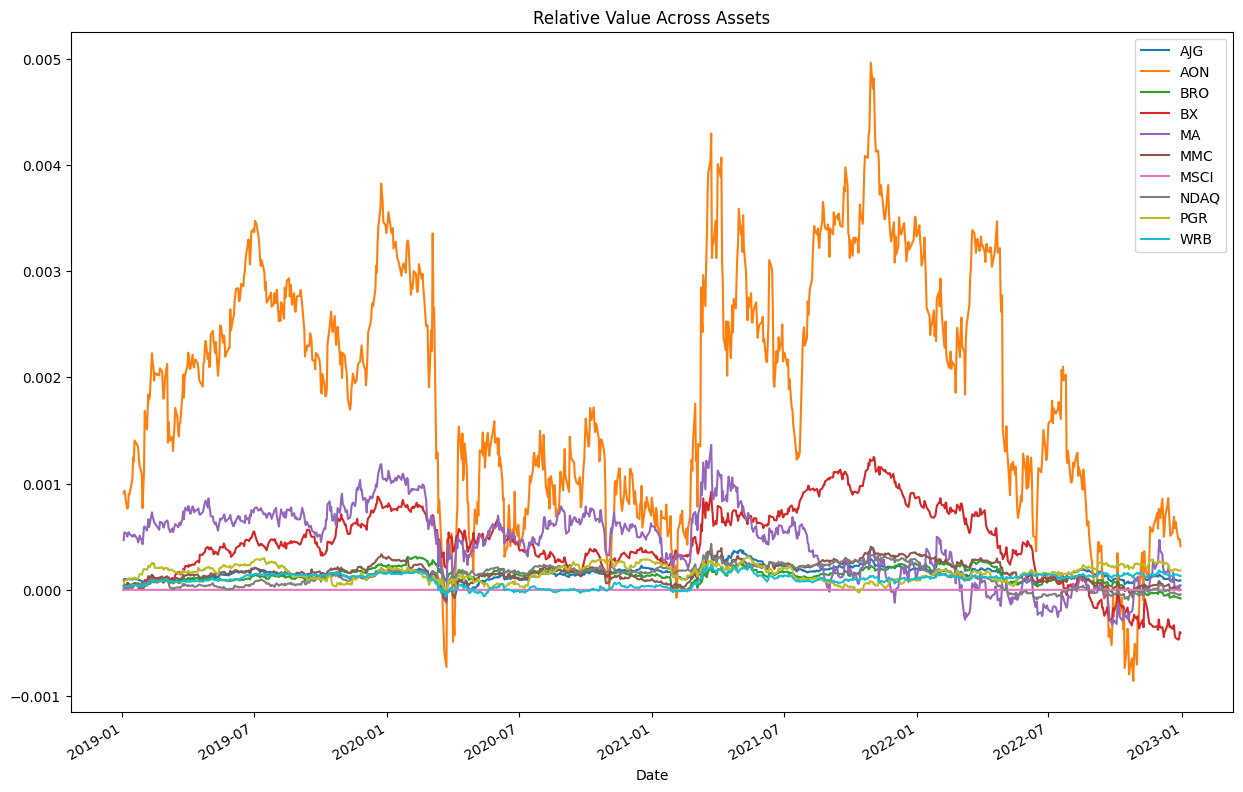

In [23]:
# Plot the relative values
rolling_relative_scores.plot(figsize=(15, 10), title='Relative Value Across Assets')
# Show the plot
plt.show()